In [1]:
%load_ext autoreload
%autoreload 2
filename = "scale-nop.csv"
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("tab10")

import warnings
warnings.filterwarnings('ignore')

In [25]:
from viz import load_and_save_hivemind_runs_nop
load_and_save_hivemind_runs_nop(filename)

scanning run jtpjk57a
scanning run 2f1p8s6s
scanning run 2angaknj
scanning run 1c1vbnob
scanning run 1003a3ws
scanning run 3m66e3ef
scanning run 24s2z8vq
scanning run 1kohz96u
scanning run 1csrpfan
scanning run msgd9vst
scanning run eojd6h75
scanning run 3upfl49f
scanning run 3br0vvc3
scanning run 2xx6v7tp
scanning run 2feaaa1t
scanning run 1nlvqs42
scanning run 2bokqof1
scanning run r7nkg2zo
scanning run 3vo5147s
scanning run 3cxc8tlg
scanning run 3bz7g516
scanning run 3548e4fi
scanning run 2kk8kbrf
scanning run 1r3cmimu
scanning run mj1k41f4
scanning run 2scvi24k
scanning run 24ipifgi
scanning run jspzu3aw
scanning run a8m8lq27
scanning run 2zrxtg1t
scanning run 2ww7p7uv
scanning run 1bofmk6f
scanning run pjipvdl9
scanning run 30b17c62
scanning run 5nwq0uhl
scanning run 3r87x6s1
scanning run 3d6jk3lf
scanning run 2c2d8rqv
scanning run 2acfmqao
scanning run 13h37ixy
scanning run jkay0eih
scanning run eoivswgx
scanning run 3ncbyees
scanning run 22wd79kf
scanning run 22lbvbvt
scanning r

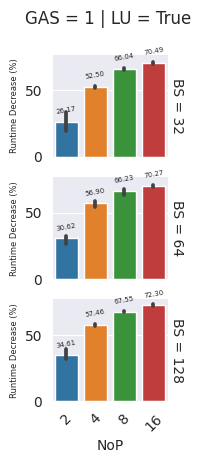

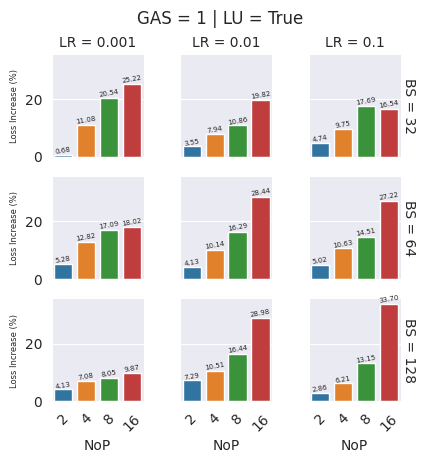

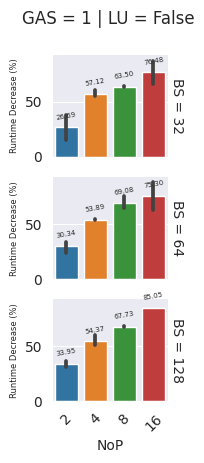

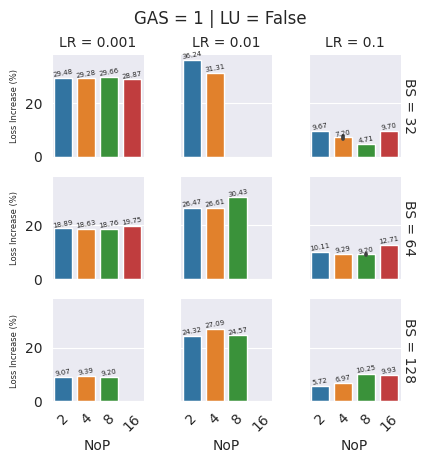

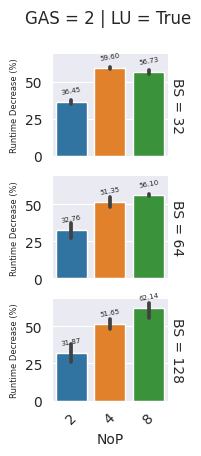

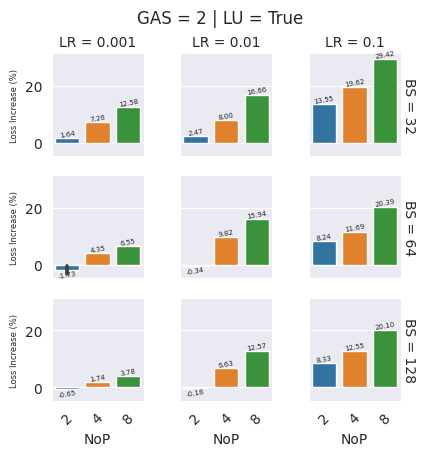

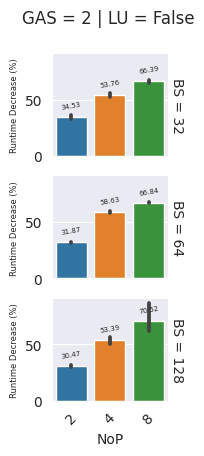

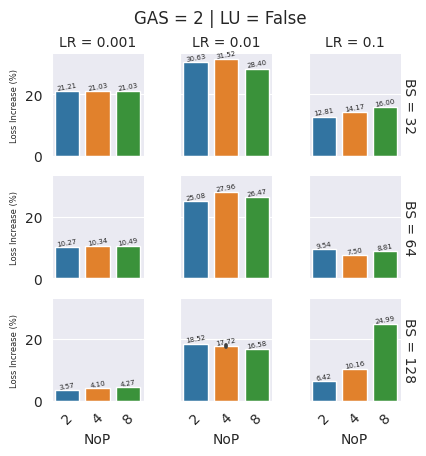

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from viz import load_baseline_data, find_baseline, print_increase_info, calc_increase_info

group_by = ["number_of_nodes", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates", "run_name"]
ascending = [True, False, True, True, True, False]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
baseline_data = load_baseline_data()

summary_data = summary_data.groupby(by=group_by)["_runtime", "train/samples_ps", "train/loss", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"].describe().reset_index()
summary_data["_runtime_max"] = summary_data["_runtime"]["max"]

# temporary
# summary_data = summary_data[summary_data["gradient_accumulation_steps"] == 1]

def calculate_runtime_increase(row):
    baseline_run = find_baseline(baseline_data, row["batch_size_per_step"].item(), row["optimizer_params.lr"].item(), row["gradient_accumulation_steps"].item())
    if baseline_run is not None:
        increase_value, increase_sign, increase_color = calc_increase_info(row["_runtime_max"].item(), baseline_run["_runtime"]["mean"], sign=-1)
        return increase_value * (-1 if increase_sign == "-" else 1)
    return 0

def calculate_loss_increase(row):
    baseline_run = find_baseline(baseline_data, row["batch_size_per_step"].item(), row["optimizer_params.lr"].item(), row["gradient_accumulation_steps"].item())
    if baseline_run is not None:
        increase_value, increase_sign, increase_color = calc_increase_info(row["train/loss"]["min"], baseline_run["train/loss"]["mean"], sign=1)
        return increase_value * (-1 if increase_sign == "-" else 1)
    return 0

summary_data["runtime_increase"] = summary_data.apply(calculate_runtime_increase, axis=1)
summary_data["loss_increase"] = summary_data.apply(calculate_loss_increase, axis=1)
summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

# temporary
for gas in [1, 2]:
# for gas in summary_data["gradient_accumulation_steps"].unique():
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]
    for use_local_updates in [True, False]:
        data_gas_ulu = data_gas[data_gas["use_local_updates"] == use_local_updates]

        if len(data_gas_ulu) == 0:
            print(f"EMPTY | GAS = {gas} | LU = {use_local_updates}")
            continue

        g1 = sns.FacetGrid(data_gas_ulu, row="batch_size_per_step", height=1.5, margin_titles=True, gridspec_kws={"wspace":0.4}, aspect=1)
        g1.figure.suptitle(f"GAS = {gas} | LU = {use_local_updates}")
        g1.set_xticklabels(rotation=45)

        g2 = g1.map_dataframe(sns.barplot, x="number_of_nodes", y="runtime_increase", dodge=False, order=data_gas_ulu["number_of_nodes"].unique(), palette="tab10")
        for axlist in g2.axes:
            for ax in axlist:
                for i in ax.containers:
                    ax.bar_label(i, fmt="%.2f", fontsize=5, rotation=10, padding=5)

        g1.set_titles(row_template="BS = {row_name}", col_template="LR = {col_name}")
        g1.set_xlabels("NoP")
        g1.set_ylabels("Runtime Decrease (%)", clear_inner=True, fontsize=6)
        g1.tight_layout()
        g1.figure.savefig(f"../../figures/06_barplot-runtime_gas-{gas}_lu-{use_local_updates}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
        plt.show()


        g1 = sns.FacetGrid(data_gas_ulu, row="batch_size_per_step", col="optimizer_params.lr", height=1.5, margin_titles=True, gridspec_kws={"wspace":0.4}, aspect=1)
        g1.figure.suptitle(f"GAS = {gas} | LU = {use_local_updates}")
        g1.set_xticklabels(rotation=45)
        g2 = g1.map_dataframe(sns.barplot, x="number_of_nodes", y="loss_increase", dodge=False, order=data_gas_ulu["number_of_nodes"].unique(), palette="tab10")
        for axlist in g2.axes:
            for ax in axlist:
                for i in ax.containers:
                    ax.bar_label(i, fmt="%.2f", fontsize=5, rotation=10)

        g1.set_titles(row_template="BS = {row_name}", col_template="LR = {col_name}")
        g1.set_xlabels("NoP")
        g1.set_ylabels("Loss Increase (%)", clear_inner=True, fontsize=6)
        g1.figure.savefig(f"../../figures/06_barplot-loss_gas-{gas}_lu-{use_local_updates}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
        plt.show()



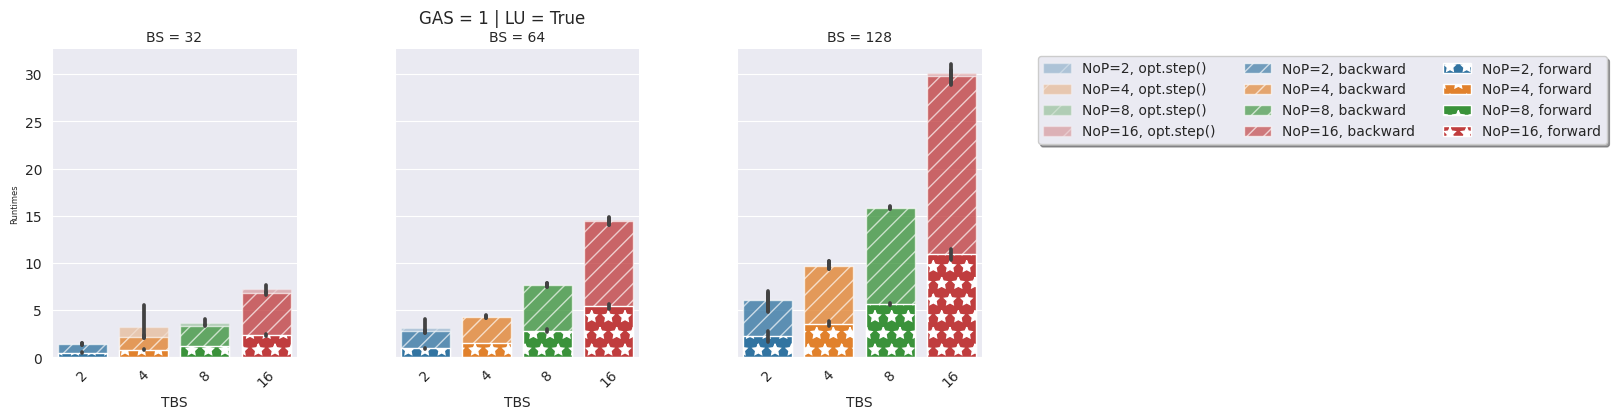

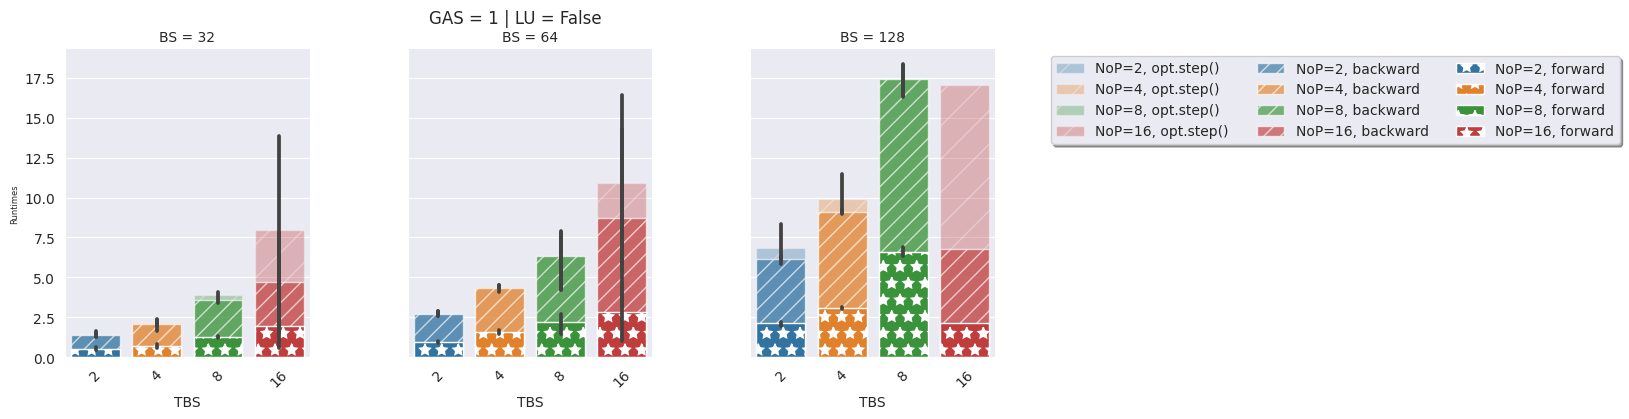

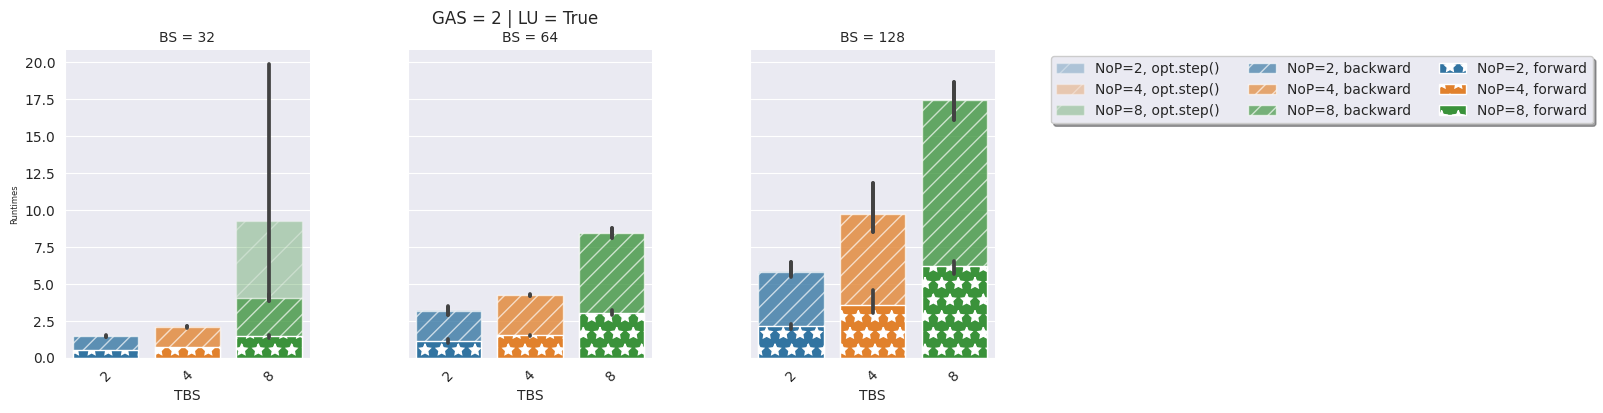

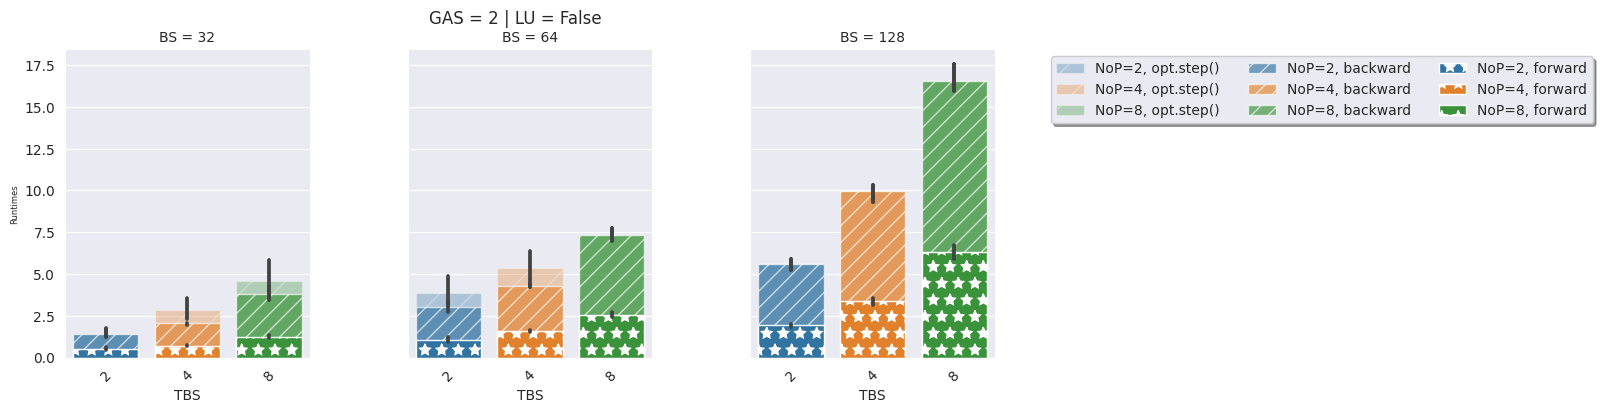

In [22]:
import itertools
import pandas as pd

group_by = ["number_of_nodes", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates", "run_name"]
ascending = [True, False, True, True, True, False]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")

summary_data = summary_data.groupby(by=group_by)["_runtime", "train/samples_ps", "train/loss", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"].describe().reset_index()
summary_data["_runtime_max"] = summary_data["_runtime"]["max"]

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

def stacked_bar(x, color, data, **kwargs):
    base_labels = data["number_of_nodes"].unique()
    forward_cumulated_column = data["train/model_forward_s"]["mean"]
    forward_labels = [f"NoP={tbs}, forward" for tbs in base_labels]
    backward_cumulated_column = forward_cumulated_column + data["train/model_backward_only_s"]["mean"]
    backward_labels = [f"NoP={tbs}, backward" for tbs in base_labels]
    opt_cumulated_column = backward_cumulated_column + data["train/model_opt_s"]["mean"]
    opt_labels = [f"NoP={tbs}, opt.step()" for tbs in base_labels]

    sns.barplot(data, x=x, y=opt_cumulated_column, alpha=0.33, label=opt_labels, hatch="/", **kwargs)
    sns.barplot(data, x=x, y=backward_cumulated_column, alpha=0.66, label=backward_labels, hatch="//", **kwargs)
    sns.barplot(data, x=x, y=forward_cumulated_column, alpha=1, label=forward_labels, hatch="*", **kwargs)

for gas in [1, 2]:
# for gas in summary_data["gradient_accumulation_steps"].unique():
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]
    for use_local_updates in [True, False]:
        data_gas_ulu = data_gas[data_gas["use_local_updates"] == use_local_updates]
        g1 = sns.FacetGrid(data_gas_ulu, col="batch_size_per_step", height=4, margin_titles=True, gridspec_kws={"wspace":0.4})
        g1.figure.suptitle(f"GAS = {gas} | LU = {use_local_updates}\n")
        g1.set_xticklabels(rotation=45)

        g2 = g1.map_dataframe(
            stacked_bar,
            x="number_of_nodes",
            dodge=False,
            order=data_gas_ulu["number_of_nodes"].unique(),
            palette="tab10",
            linewidth=1,
        )

        ax = plt.gca()
        ax.legend(bbox_to_anchor=(1.2, 1), ncol=3, fancybox=True, shadow=True, prop={"size": 10})

        g1.set_titles(col_template="BS = {col_name}")
        g1.set_xlabels("TBS")
        g1.set_ylabels("Runtimes", clear_inner=True, fontsize=6)
        g1.tight_layout()
        g1.figure.savefig(f"../../figures/06_barplot-times_gas-{gas}_lu-{use_local_updates}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
        plt.show()



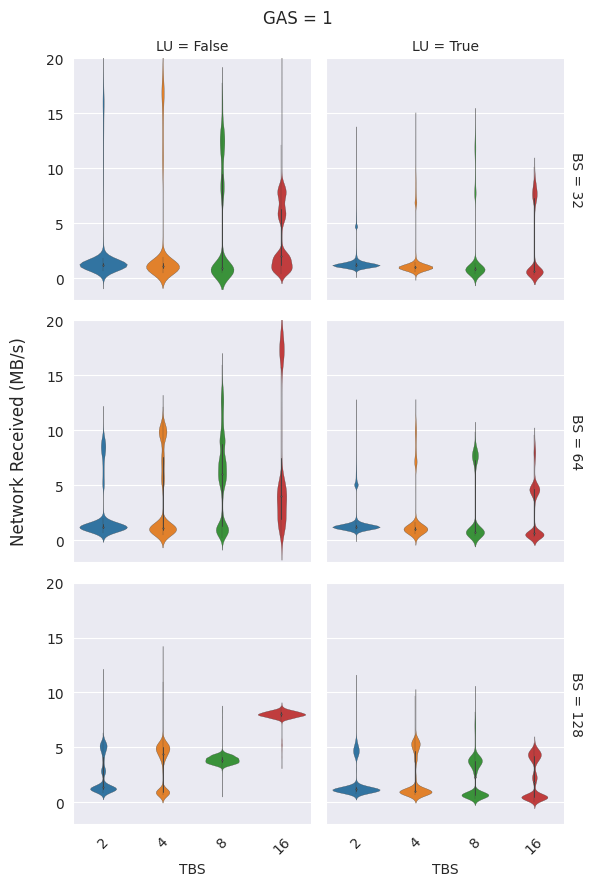

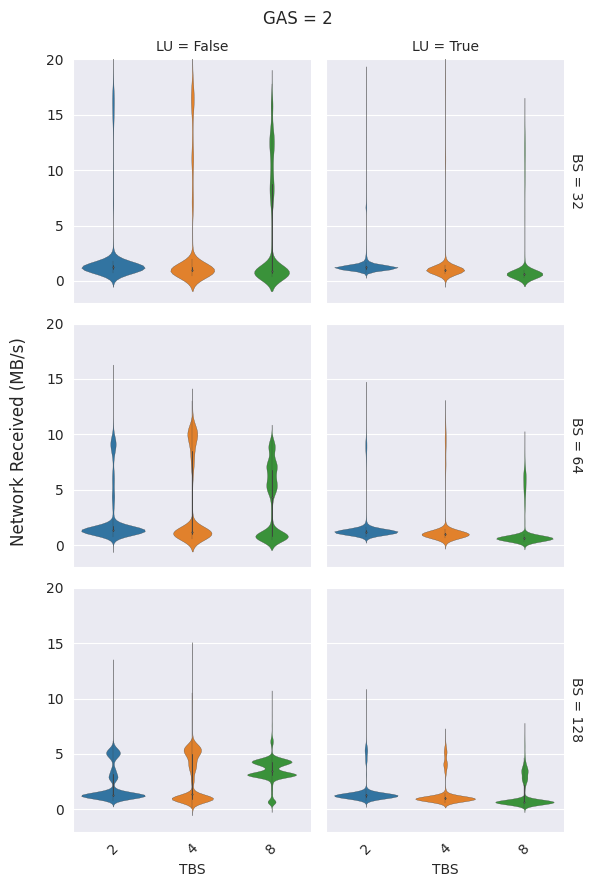

In [25]:
from viz import viz_column_all
viz_column_all("06", filename, "bandwidth/net_recv_sys_bandwidth_mbs", ylabel="Network Received (MB/s)", is_nop=True, ylim=(-2, 20))

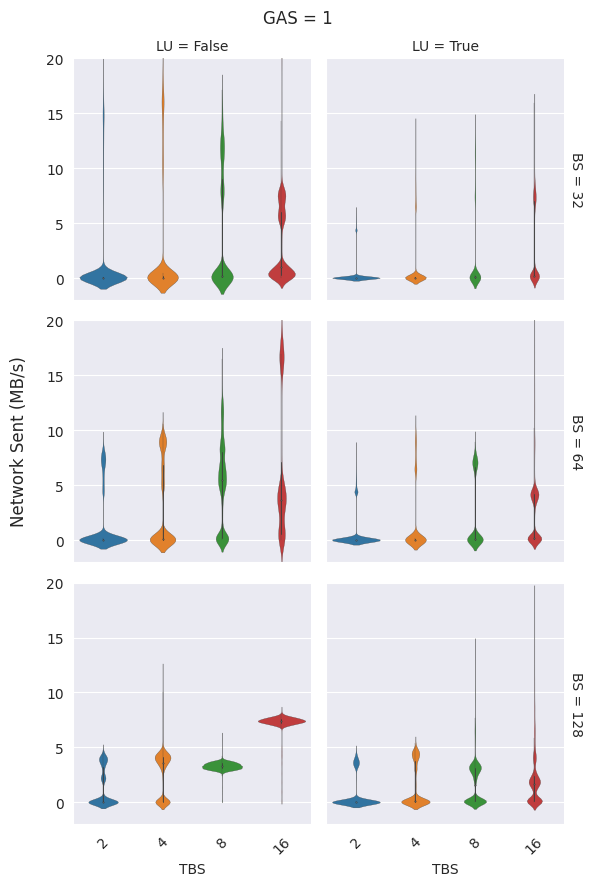

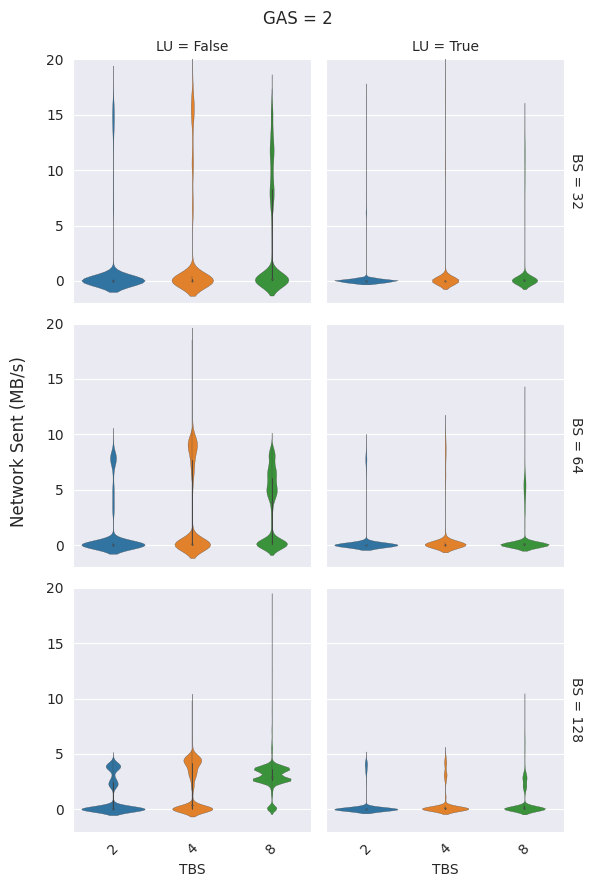

In [26]:
from viz import viz_column_all
viz_column_all("06", filename, "bandwidth/net_sent_sys_bandwidth_mbs", ylabel="Network Sent (MB/s)", is_nop=True, ylim=(-2, 20))

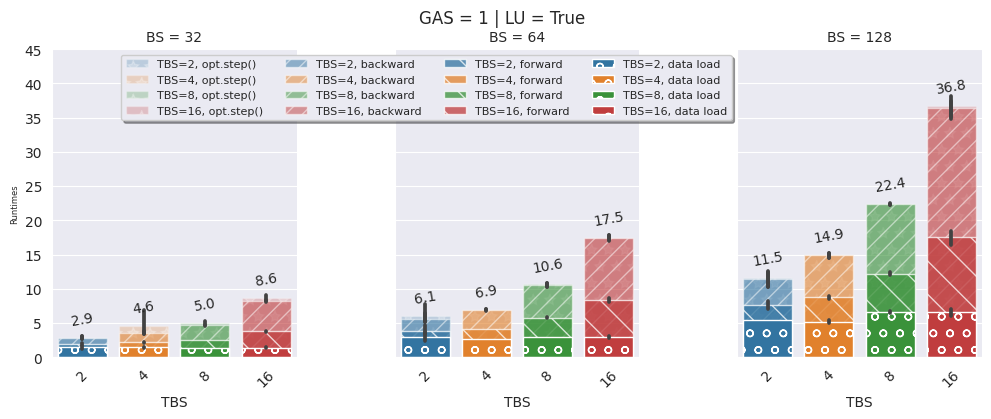

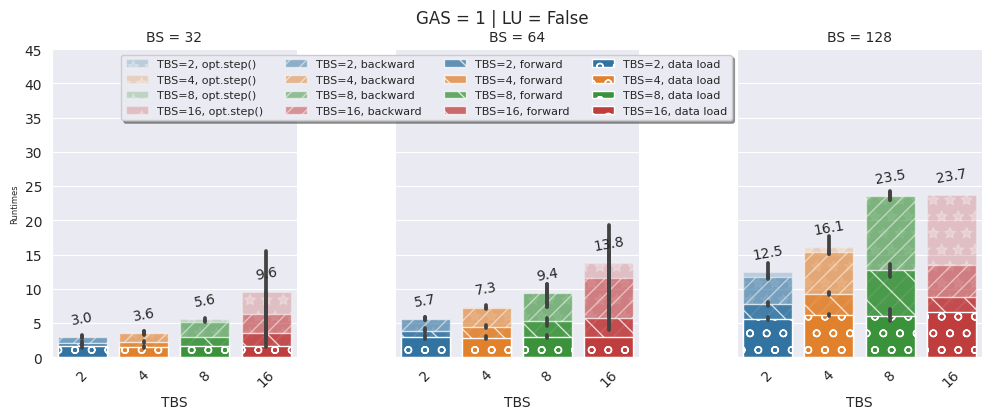

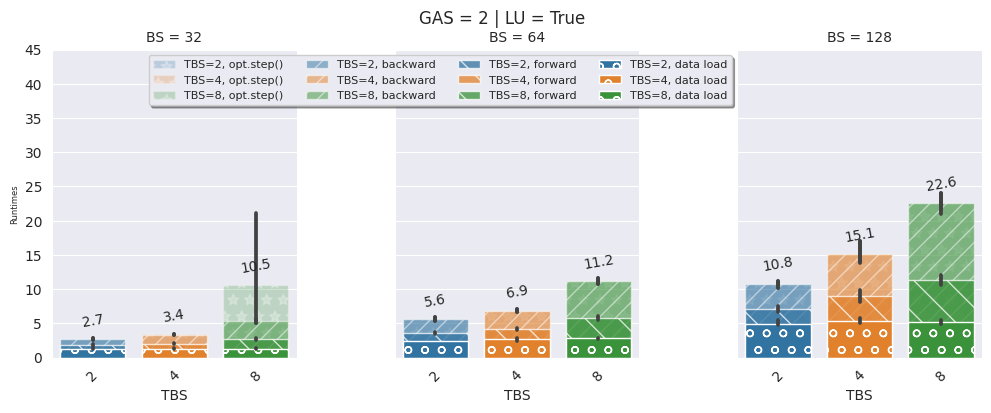

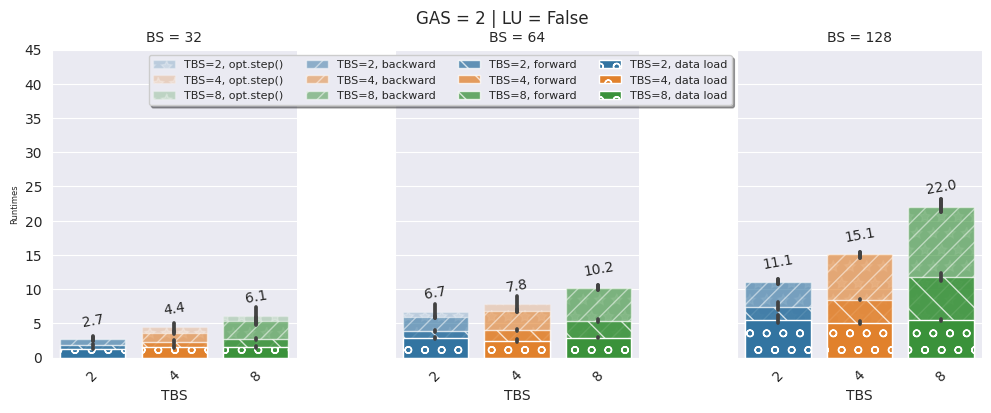

In [27]:
import itertools
import pandas as pd

group_by = ["number_of_nodes", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates", "run_name"]
ascending = [True, False, True, True, True, False]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")

summary_data = summary_data.groupby(by=group_by)["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"].describe().reset_index()

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

def stacked_bar(x, color, data, **kwargs):
    base_labels = data["number_of_nodes"].unique()
    data_cumulated_column = data["train/data_load_s"]["mean"]
    data_labels = [f"TBS={tbs}, data load" for tbs in base_labels]
    forward_cumulated_column = data_cumulated_column + data["train/model_forward_s"]["mean"]
    forward_labels = [f"TBS={tbs}, forward" for tbs in base_labels]
    backward_cumulated_column = forward_cumulated_column + data["train/model_backward_only_s"]["mean"]
    backward_labels = [f"TBS={tbs}, backward" for tbs in base_labels]
    opt_cumulated_column = backward_cumulated_column + data["train/model_opt_s"]["mean"]
    opt_labels = [f"TBS={tbs}, opt.step()" for tbs in base_labels]

    sns.barplot(data, x=x, y=opt_cumulated_column, alpha=0.25, label=opt_labels, hatch="*", **kwargs)
    sns.barplot(data, x=x, y=backward_cumulated_column, alpha=0.50, label=backward_labels, hatch="//", **kwargs)
    sns.barplot(data, x=x, y=forward_cumulated_column, alpha=0.75, label=forward_labels, hatch="\\", **kwargs)
    ax = sns.barplot(data, x=x, y=data_cumulated_column, alpha=1, label=data_labels, hatch="o", **kwargs)
    for i, container in enumerate(ax.containers):
        if i % 4 == 0:
            ax.bar_label(container, fmt="%.1f", rotation=10, padding=7)

for gas in [1, 2]:
# for gas in summary_data["gradient_accumulation_steps"].unique():
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]
    for use_local_updates in [True, False]:
        data_gas_ulu = data_gas[data_gas["use_local_updates"] == use_local_updates]
        g1 = sns.FacetGrid(data_gas_ulu, col="batch_size_per_step", height=4, margin_titles=True, gridspec_kws={"wspace":0.4})
        g1.figure.suptitle(f"GAS = {gas} | LU = {use_local_updates}\n")
        g1.set_xticklabels(rotation=45)

        g2 = g1.map_dataframe(
            stacked_bar,
            x="number_of_nodes",
            dodge=False,
            order=data_gas_ulu["number_of_nodes"].unique(),
            palette="tab10",
            linewidth=1,
        )

        ax = plt.gca()
        ax.legend(bbox_to_anchor=(0, 1), ncol=4, fancybox=True, shadow=True, prop={"size": 8})
        plt.ylim(top=45)

        g1.set_titles(col_template="BS = {col_name}")
        g1.set_xlabels("TBS")
        g1.set_ylabels("Runtimes", clear_inner=True, fontsize=6)
        g1.tight_layout()
        g1.figure.savefig(f"../../figures/06_barplot-times_gas-{gas}_lu-{use_local_updates}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
        plt.show()

